In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score,recall_score,accuracy_score

In [24]:
DATASET = "ENCODE"

columns_before_attributes = 4
frame = pd.read_csv("../Datasets/ENCODE/ENCODE_SPLIT.csv")
    
EPOCHS = 71


FOLDER = "Learning_rate_2e-4"

In [25]:
def create_classification_list(frame, columns_before_attributes):
    columns = frame.columns[columns_before_attributes:].values
    result_columns = []
    for col in columns:
        values_list = [col + "_" + x for x in list(set(frame[col].values))]
        result_columns.append(values_list)
    return result_columns

In [26]:
attributes_list = create_classification_list(frame, columns_before_attributes)
limits = []
tot_length = 0
for attr in attributes_list:
    tot_length += len(attr)
    limits.append(tot_length)
    

In [27]:
gpt2_results = pd.read_csv("Results/GPT2_48epochs_early_stopping_1st_train.csv")
lstm_results = pd.read_csv("Results/LSTM_results_22epochs.csv")
roberta_results = pd.read_csv("Results/RoBERTa_results/Learning_rate_2e-4/test_outputs_epoch71.csv")
roberta_raw_target = pd.read_csv("Data/roberta_testset.csv")

In [22]:
index = 1200
print(gpt2_results.iloc[index].Target.split("=")[0])
print(gpt2_results.iloc[index].Target.split("=")[1])

datatype: DnaseSeq; datatype description: DNaseI HS Sequencing; labversion: baseAlignCounts.pl v 1,fseq v 1.84, iff_generic_male,p-value cutoff: 0.05; replicate: 1,2; cell: Colo829; cell organism: human; cell description: malignant melanoma; cell karyotype: cancer; cell sex: M; labversion: baseAlignCounts.pl v 1 Duke human Colo829 DNase-seq COLO829 malignant melanoma 
Assay name: DNase-seq - Assay type: DNA accessibility - Target of assay: None - Genome assembly: GRCh38,hg19 - Biosample term name: COLO829 - Project: ENCODE - Organism: Homo sapiens - Life stage: adult - Age: 45 - Age units: year - Sex: male - Ethnicity: Caucasian - Health status: metastatic melanoma - Classification: cell line - Investigated as: None $


In [7]:
gpt2_predicted = [x.split("= ")[-1].replace(" $","").replace(" <pad>" , "").lower() for x in gpt2_results.Predicted.values]
gpt2_target = [x.split("=")[-1].replace(" $","").lower() for x in gpt2_results.Target.values]

lstm_predicted = [x.replace(" <end>","") for x in lstm_results.Predicted.values]
lstm_target = [x.replace(" <end>","") for x in lstm_results.Target.values]

In [28]:
attribute_names = ['Assay name','Assay type','Target of assay','Genome assembly','Biosample term name','Project','Organism','Life stage','Age','age units','Sex','Ethnicity','Health status','Classification','Investigated as']
attributes = ['assay name: ','assay type: ','target of assay: ','genome assembly: ','biosample term name: ','project: ','organism: ','life stage: ','age: ','age units: ','sex: ','ethnicity: ','health status: ','classification: ','investigated as: ']

In [29]:
def get_list_of_values(predicted, target):    
    predicted_values = []
    target_values = []
    errors = []
    for pr,tg in zip(predicted, target):
        try:
            tmp_pr = []
            tmp_tg = []
            for i in range(len(attributes) - 1):
                if(attributes[i] in pr):
                    tmp_pr.append(pr.split(attributes[i])[1].split(' - ')[0])
                else:
                    tmp_pr.append("<missing>")
                if(attributes[i] in tg):
                    tmp_tg.append(tg.split(attributes[i])[1].split(' - ')[0])
                else:
                    tmp_tg.append("<missing>")
            if(attributes[i + 1] in pr):
                tmp_pr.append(pr.split(attributes[i + 1])[1])
            else:
                tmp_pr.append("<missing>")
            if(attributes[i + 1] in tg):
                tmp_tg.append(tg.split(attributes[i + 1])[1])
            else:
                tmp_tg.append("<missing>")
            predicted_values.append(tmp_pr)
            target_values.append(tmp_tg)
        except:
            errors.append([pr,tg])
    return predicted_values, target_values, errors

In [30]:
print("Iterating over test_set lines...")
robe_predicted_values = []
robe_target_values = []
for i, item in roberta_raw_target.iterrows():
    one_hot_target = np.array(item['labels'][1:-1].split(", "), dtype = int)    
    float_prediction = np.array(roberta_results.iloc[i].values)
    predicted_indexes = []
    #Take the last 4 elements of the argosrt (indices that where = 1) and sort the result
    target_indexes = list(np.sort(np.argsort(np.array(item['labels'][1:-1].split(", "), dtype = int))[-len(attributes):]))
    for i in range(len(attributes)):
        if(i== 0):
            predictions_for_attribute = float_prediction[:limits[i]]
            max_index = np.argmax(predictions_for_attribute)
        elif(i == len(attributes) - 1):
            predictions_for_attribute = float_prediction[limits[i - 1]:]
            max_index = np.argmax(predictions_for_attribute) + limits[i - 1]
        else:
            predictions_for_attribute = float_prediction[limits[i-1]:limits[i]]
            max_index = np.argmax(predictions_for_attribute) + limits[i - 1]
        predicted_indexes.append(max_index)
    robe_predicted_values.append(predicted_indexes)
    robe_target_values.append(target_indexes)

Iterating over test_set lines...


In [11]:
index = 0
print(robe_predicted_values[index])
print(robe_target_values[index])

[24, 26, 126, 389, 398, 821, 823, 840, 959, 1016, 1027, 1042, 1070, 1111, 1124]
[24, 26, 126, 379, 398, 821, 823, 840, 959, 1016, 1027, 1042, 1070, 1111, 1124]


In [31]:
gpt2_predicted_values, gpt2_target_values, gpt2_errors = get_list_of_values(gpt2_predicted, gpt2_target)
lstm_predicted_values, lstm_target_values, lstm_errors = get_list_of_values(lstm_predicted, lstm_target)

In [32]:
def compute_pr_re_acc(predicted_values, target_values):
    precisions = []
    recalls = []
    accuracies = []
    for i in range(len(attributes)):
        predictions = [x[i] for x in predicted_values]
        target = [x[i] for x in target_values]
        precisions.append(precision_score(target, predictions, average='weighted'))
        recalls.append(recall_score(target, predictions, average='weighted'))
        accuracies.append(accuracy_score(target,predictions))
    return precisions, recalls, accuracies

In [33]:
gpt2_prec, gpt2_rec, gpt2_acc = compute_pr_re_acc(gpt2_predicted_values, gpt2_target_values)
lstm_prec, lstm_rec, lstm_acc = compute_pr_re_acc(lstm_predicted_values, lstm_target_values)
robe_prec, robe_rec, robe_acc = compute_pr_re_acc(robe_predicted_values, robe_target_values)

/home/cannizzaro/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/cannizzaro/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [35]:
attributes

['assay name: ',
 'assay type: ',
 'target of assay: ',
 'genome assembly: ',
 'biosample term name: ',
 'project: ',
 'organism: ',
 'life stage: ',
 'age: ',
 'age units: ',
 'sex: ',
 'ethnicity: ',
 'health status: ',
 'classification: ',
 'investigated as: ']

In [40]:
gpt2_rec[10]

0.9629748873148745

In [42]:
sum(robe_rec)/len(robe_acc)

0.9020048115477145

In [58]:
sum(lstm_acc)/15

0.18998107758191415

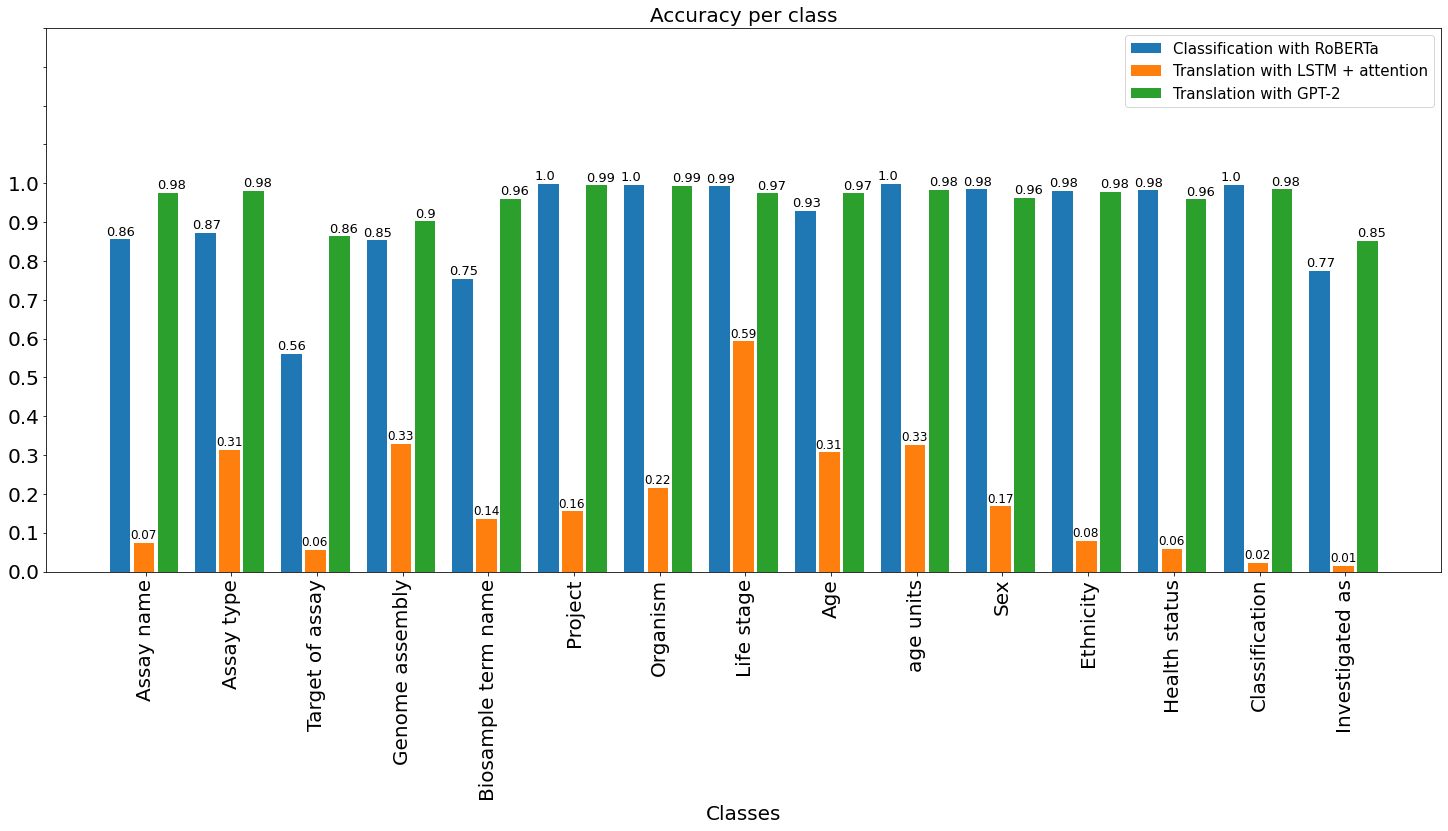

In [19]:
width = 1.5
x = np.arange(0,len(attribute_names)*(1+width),1+width)
fig = plt.figure(figsize = (25,10))
ax = plt.subplot(111)
x_label = attribute_names
y_1 = lstm_rec
y_2 = gpt2_acc
y_3 = robe_acc
robe_plot = ax.bar(x , y_3, width - 0.9, label = "Classification with RoBERTa")
lstm_plot = ax.bar(x + width - 0.8,y_1, width - 0.9, label = "Translation with LSTM + attention")
gpt2_plot = ax.bar(x + width - 0.1,y_2,width - 0.9, label = "Translation with GPT-2")

ax.set_xlabel('Classes', fontsize = 20)
ax.set_title("Accuracy per class", fontsize = 20)
ax.set_ylim(0,1.1)
ax.set_xticks(x + width/2)
ax.set_xticklabels(x_label, fontsize = 20, rotation = "vertical")
ax.set_yticks(np.arange(0,1.5,0.1))
ax.set_yticklabels([str(round(x,2)) for x in np.arange(0,1.1,0.1)], fontsize = 20)

ax.legend(fontsize = 15)

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(len(x))]
for i in range(len(y_1)):
    ax.text(x[i] - 0.4, y_3[i]+0.01, str(round(y_3[i],2)), fontsize = 13)
    ax.text(x[i] + 0.3, y_1[i]+0.01, str(round(y_1[i],2)), fontsize = 12)
    ax.text(x[i] + 1.1, y_2[i]+0.01, str(round(y_2[i],2)), fontsize = 13)
